In [1]:
import qutip
from qutip import basis, ket2dm, rand_ket, rand_dm, qeye, expect, tensor,identity
from enum import Enum
import numpy as np
from matplotlib import pyplot as plt
import scqubits
from typing import List
from qiskit.algorithms.optimizers import COBYLA,ISRES,CRS,DIRECT_L
from IPython.display import clear_output
from math import sqrt

In [16]:
g = 0.03
A = 0.03

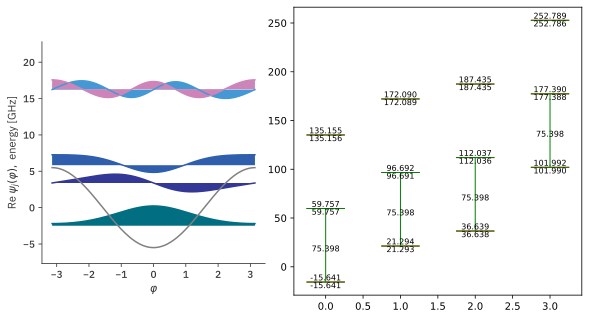

In [17]:


params = [6,5]
qubit = scqubits.Transmon(EJ = 5.5,
                            EC = 1,
                            ng = 0,
                            ncut = 30)
osc = scqubits.Oscillator(
    E_osc=12,
    l_osc = 2,
    truncated_dim=8
)
hilbertspace = scqubits.HilbertSpace([qubit, osc])
hilbertspace.add_interaction(
    g_strength=g, op1=qubit.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.generate_lookup()
dessed_indices = [hilbertspace.dressed_index((0,0)),
                  hilbertspace.dressed_index((0,1)),
                  hilbertspace.dressed_index((1,0)),
                  hilbertspace.dressed_index((1,1)),
                  hilbertspace.dressed_index((2,0)),
                  hilbertspace.dressed_index((2,1))]
if None in dessed_indices:
    print('contain none')



def plot_specturum(qubit, osc, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]],message = ''):
    energy_text_size = 8
    clear_output(wait=True)
    qubit_ori_energies = qubit.eigenvals(max_qubit_level)
    resonator_ori_energies = osc.eigenvals(max_resonator_level)
    fig, old_ax = qubit.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = hilbertspace.dressed_index((ql,rl))
            if dressed_state_index != None:
                dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
                ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
                ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')
            else:
                print("dressed_state_index contain None")

    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = hilbertspace.dressed_index((state1[0],state1[1]))
        dressed_index2 = hilbertspace.dressed_index((state2[0],state2[1]))
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()

plot_specturum(qubit, osc, hilbertspace)

In [18]:
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
def truncate(operator: qutip.Qobj, dimension: int) -> qutip.Qobj:
    return qutip.Qobj(operator[:dimension, :dimension])
total_truncation = 30
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

product_states = [(0, 0), (1, 0), (0, 1), (1, 1)]
idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
qutip_states = [qutip.basis(total_truncation, idx) for idx in idxs]
a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
a = truncate(a, total_truncation)

def transition_frequency(s0: int, s1: int) -> float:
    return (
        abs(
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2 * np.pi
    )

In [19]:
def do_plots(omega_d,t_tot):
    # Plot the dressed state populations under drive
    #cos pulse
    def drive_coeff(t: float, *args: dict) -> float:
        return A * np.cos(omega_d * t)


    a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
    a = truncate(a, total_truncation)

    H_with_drive = [
        diag_dressed_hamiltonian_trunc,
        [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
    ]

    product_states = [(0, 0), (1, 0), (2,0), (0, 1), (1, 1), (2,1),(0,2)]
    idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
    qutip_states = [qutip.basis(total_truncation, idx) for idx in idxs]
    tlist = np.linspace(0, t_tot, t_tot*4)
    results = []
    for i in range(3):
        temp = qutip.sesolve(
            H = H_with_drive,
            psi0 = qutip.basis(total_truncation, hilbertspace.dressed_index((i,0))),
            tlist = tlist,
            e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                                a.dag()*a, #photon number
                                                                0.5*(a+a.dag()), # real alpha
                                                                -0.5*1j*(a-a.dag())# imag alpha
                                                                ],
            options=qutip.Options(store_final_state=True)
        )
        results.append(temp)

    dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}

    fig, axes = plt.subplots(4, 3, figsize=(9, 6))

    for i in range(3):
        for idx, res in zip(idxs, results[i].expect):
            product_state = product_states[idxs.index(idx)]
            qubit_state = dictionary[product_state[0]]
            resonator_state = product_state[1]
            axes[0][i].plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
        alpha = results[i].expect[-4]*np.exp(1j*omega_d*tlist)
        real = alpha.real
        imag = alpha.imag
        axes[0][i].plot(tlist, results[i].expect[-3], label=r"photon number")
        axes[1][i].plot(tlist,imag , label=r"imag alpha")
        axes[2][i].plot(tlist, real, label=r"real alpha")
        axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

    axes[0][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
    axes[1][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
    axes[2][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
    axes[3][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
    plt.ylabel("population")
    plt.xlabel("t (ns)")
    for row in range(4):
        max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
        for col in [0,1,2]:
            ymin, ymax = axes[row][col].get_ylim()
            xmin, xmax = axes[row][col].get_xlim()
            if ymax > max_y_range:
                max_y_range = ymax
            if ymin < min_y_range:
                min_y_range = ymin
            if xmax > max_x_range:
                max_x_range = xmax
            if xmin < min_x_range:
                min_x_range = xmin
        for col in [0,1,2]:
            axes[row][col].set_ylim(min_y_range, max_y_range)
            axes[row][col].set_xlim(min_x_range,max_x_range)
    # plt.yscale('log')
    plt.figure()
    plt.plot(tlist,results[0].expect[-3],label='g0 photon #')
    plt.plot(tlist,results[1].expect[-3],label='e0 photon #')
    plt.plot(tlist,results[2].expect[-3],label='f0 photon #')
    plt.legend()
    plt.xlim(100,180)
    plt.ylim(0,1)
    plt.show()

    return results

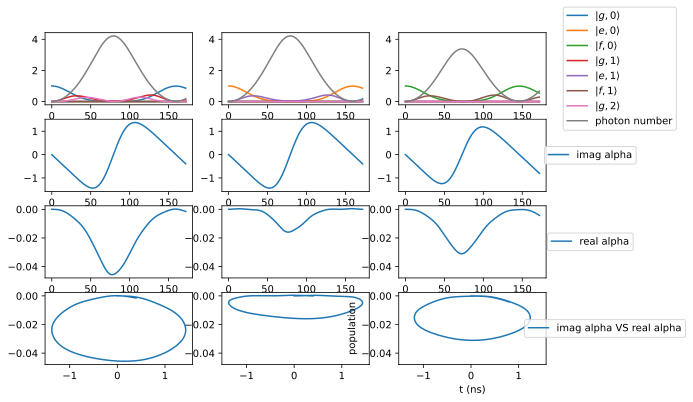

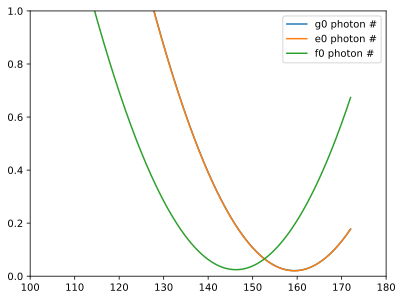

In [20]:
omega_e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
A = 0.01
t_tot = 172 # ns


results_e0e1 = do_plots(omega_e0e1,t_tot)



10.0%. Run time:  12.39s. Est. time left: 00:00:01:51
20.0%. Run time:  28.98s. Est. time left: 00:00:01:55
30.0%. Run time:  45.53s. Est. time left: 00:00:01:46
40.0%. Run time:  65.15s. Est. time left: 00:00:01:37
50.0%. Run time:  88.58s. Est. time left: 00:00:01:28
60.0%. Run time: 112.13s. Est. time left: 00:00:01:14
70.0%. Run time: 135.89s. Est. time left: 00:00:00:58
80.0%. Run time: 159.55s. Est. time left: 00:00:00:39
90.0%. Run time: 183.08s. Est. time left: 00:00:00:20
Total run time: 206.34s


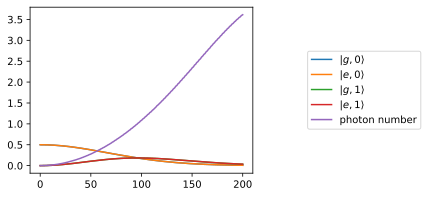

In [136]:
# resonator decay constant

g0g1 = transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))
e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
kappa = 2*abs(g0g1-e0e1)
omega_d = (e0e1+g0g1)/2
A = sqrt(10)*kappa

tlist = np.linspace(0, 200, 1000)

def drive_coeff(t: float, *args: dict) -> float:
    return A * np.cos(omega_d * t)
H_with_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
]

superposition01 = 1/np.sqrt(2)*qutip.basis(total_truncation, hilbertspace.dressed_index((0,0)))\
                   +1/np.sqrt(2)*qutip.basis(total_truncation, hilbertspace.dressed_index((1,0)))
result = qutip.mesolve(
    H = H_with_drive,
    rho0 = superposition01,
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    c_ops=[np.sqrt(kappa) * a],
    options=qutip.Options(store_final_state=True),
    progress_bar = True
)
fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))

dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
for idx, res in zip(idxs, result.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax1.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
ax1.plot(tlist, result.expect[-1], label=r"photon number")
ax1.legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))

plt.show()

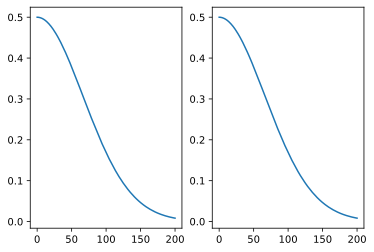

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].plot(tlist,result.expect[0])
axes[1].plot(tlist,result.expect[1])

In [138]:
kappa

0.0010773147012912432